In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(""), ".."))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from src._pipeline import PreprocessingPipeline

In [4]:
df = pd.read_csv('../data/loan_data_set.csv')

In [5]:
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [7]:
pipeline = PreprocessingPipeline()

In [8]:
pipeline.preprocess_data(df, df, df, df,)

INFO: Starting preprocessing pipeline


INFO: Finished preprocessing pipeline


(     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
 0           0.072991          -0.554487    0.000000          0.279851   
 1          -0.134412          -0.038732   -0.219273          0.279851   
 2          -0.393747          -0.554487   -0.957641          0.279851   
 3          -0.462062           0.251980   -0.314547          0.279851   
 4           0.097728          -0.554487   -0.064454          0.279851   
 ..               ...                ...         ...               ...   
 609        -0.410130          -0.554487   -0.898095          0.279851   
 610        -0.212557          -0.554487   -1.267279         -2.518655   
 611         0.437174          -0.472404    1.269371          0.279851   
 612         0.357064          -0.554487    0.483367          0.279851   
 613        -0.134412          -0.554487   -0.159728          0.279851   
 
      Credit_History  Gender  Married  Dependents  Education  Self_Employed  \
 0          0.451640     1.0   

In [10]:
from sklearn.pipeline import Pipeline, clone
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        self.fitted_ = True
        return self

    def transform(self, X):
        check_is_fitted(self, 'fitted_')
        return X.drop(columns=self.columns_to_drop)

    def get_feature_names_out(self, input_features=None):
        return [col for col in input_features if col not in self.columns_to_drop]

class PreprocessingPipeline:
    def __init__(self):
        self._preprocessor = self._make_preprocessor()
        self._target_pipeline = self._make_target_pipeline()

    def preprocess_data(self, X_train, X_test, y_train, y_test):
        X_train = self._preprocessor.fit_transform(X_train)
        X_test = self._preprocessor.transform(X_test)
        y_train = self._target_pipeline.fit_transform(y_train)
        y_test = self._target_pipeline.transform(y_test)
        # SMOTE

        return X_train, X_test, y_train, y_test
    
    def transform_for_inference(self, X, y):
        X = self._preprocessor.transform(X)
        y = self._target_pipeline.transform(y)
        return X, y

    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(path):
        with open(path, "rb") as f:
            return pickle.load(f)
        


    def _make_preprocessor(self):
        num_pipeline = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="mean")),
                ("scaler", StandardScaler()),
            ]
        )

        cat_pipeline = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder", OrdinalEncoder()),
            ]
        )

        ct = ColumnTransformer(
            transformers=[
                (
                    "num",
                    num_pipeline,
                    make_column_selector(dtype_include=np.number),
                ),
                ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
            ],
            remainder="passthrough",
            verbose_feature_names_out=False,
            n_jobs=-1,
        )

        preprocessor = Pipeline(
            steps=[
                ("ct", ct),
                ("dropper", ColumnDropper(columns_to_drop=["Loan_ID"])),
            ]
        )
        preprocessor.set_output(transform="pandas")
        return preprocessor

    def _make_target_pipeline(self):
        return Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder", OrdinalEncoder()),
            ]
        )
    

# pipeline = PreprocessingPipeline.load('../models/preprocessing_pipeline.pkl')


In [12]:
preprocessor = PreprocessingPipeline()

In [15]:
preprocessor._make_preprocessor()

Pipeline(steps=[('ct',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7aafcfbb0bb0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7aafcfbb06a0>)],
                                   verbose_feature_names_out=False)),
                ('dropper', ColumnDropper(columns_to_drop=['Loan_ID']))])

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns='Loan_Status'), df[['Loan_Status']],
    test_size=0.2, random_state=42
)

In [11]:
X_train = preprocessor.fit_transform(X_train)
y_train = target_pipeline.fit_transform(y_train)

X_test = preprocessor.transform(X_test)
y_test = target_pipeline.transform(y_test)

NameError: name 'preprocessor' is not defined

In [56]:
X_train

,ApplicantIncome,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
83,0.083915,LP001273,Male,Yes,0,Graduate,No,2250.0,265.0,360.0,NaN,Semiurban
90,-0.429338,LP001316,Male,Yes,0,Graduate,No,2900.0,131.0,360.0,1.0,Semiurban
227,0.126095,LP001758,Male,Yes,2,Graduate,No,1695.0,210.0,360.0,1.0,Semiurban
482,-0.576970,LP002537,Male,Yes,0,Graduate,No,3150.0,128.0,360.0,1.0,Semiurban
464,-0.225522,LP002493,Male,No,0,Graduate,No,0.0,98.0,360.0,0.0,Semiurban
...,...,...,...,...,...,...,...,...,...,...,...,...
71,-0.612064,LP001245,Male,Yes,2,Not Graduate,Yes,1875.0,97.0,360.0,1.0,Semiurban
106,0.997882,LP001369,Male,Yes,2,Graduate,No,1126.0,225.0,360.0,1.0,Urban
270,-0.382264,LP001888,Female,No,0,Graduate,No,0.0,30.0,360.0,1.0,Urban
435,0.766733,LP002393,Female,NaN,NaN,Graduate,No,0.0,NaN,240.0,1.0,Semiurban


In [ ]:
jobblib.dump(preprocessor, 'preprocessor.pkl')

In [225]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [226]:
for col in df.columns:
    print(df[col].value_counts(dropna=False))
    print('\n')

Loan_ID
LP002990    1
LP001002    1
LP001003    1
LP001005    1
LP001006    1
           ..
LP001024    1
LP001020    1
LP001018    1
LP001014    1
LP001013    1
Name: count, Length: 614, dtype: int64


Gender
Male      489
Female    112
NaN        13
Name: count, dtype: int64


Married
Yes    398
No     213
NaN      3
Name: count, dtype: int64


Dependents
0      345
1      102
2      101
3+      51
NaN     15
Name: count, dtype: int64


Education
Graduate        480
Not Graduate    134
Name: count, dtype: int64


Self_Employed
No     500
Yes     82
NaN     32
Name: count, dtype: int64


ApplicantIncome
2500     9
4583     6
6000     6
2600     6
5000     5
        ..
11000    1
3416     1
1907     1
3125     1
3727     1
Name: count, Length: 505, dtype: int64


CoapplicantIncome
0.0       273
1666.0      5
2083.0      5
2500.0      5
1625.0      3
         ... 
2816.0      1
1083.0      1
3021.0      1
983.0       1
5063.0      1
Name: count, Length: 287, dtype: int64


LoanAmount
Na

In [227]:
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status', 'Loan_Amount_Term']

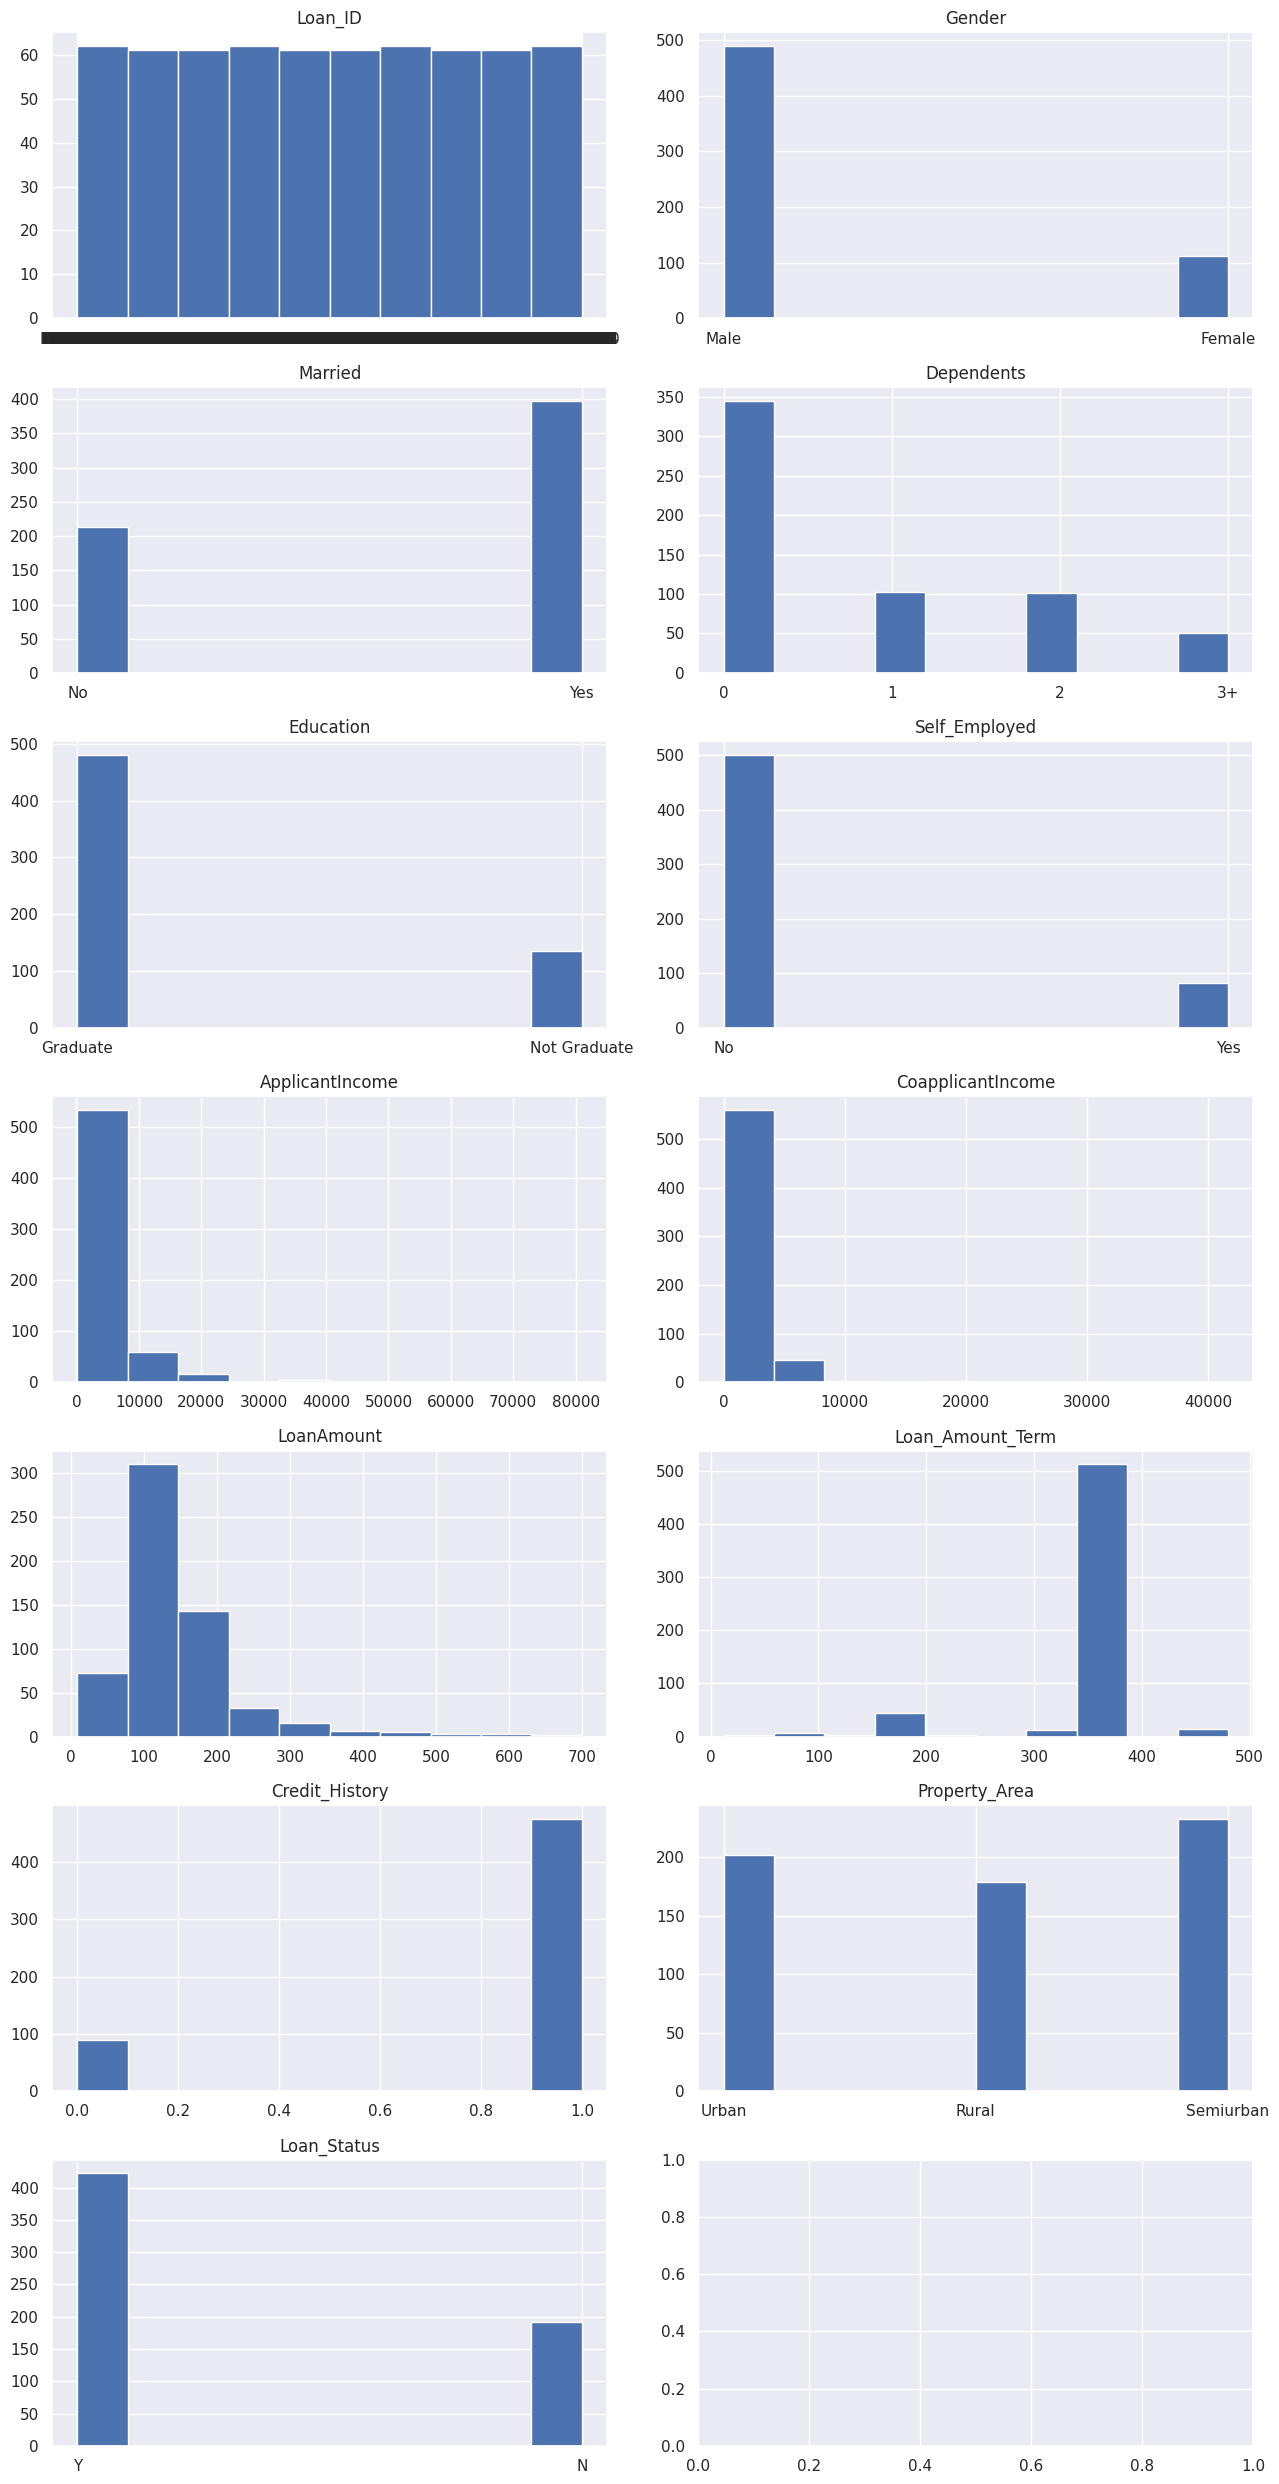

In [228]:
fig, axs = plt.subplots(7, 2, figsize=(13, 25))

for i, col in enumerate(df.columns):
    row = i // 2
    col_idx = i % 2
    axs[row, col_idx].hist(df[col].dropna())
    axs[row, col_idx].set_title(col)

plt.tight_layout()
plt.show()


<Axes: xlabel='LoanAmount', ylabel='Count'>

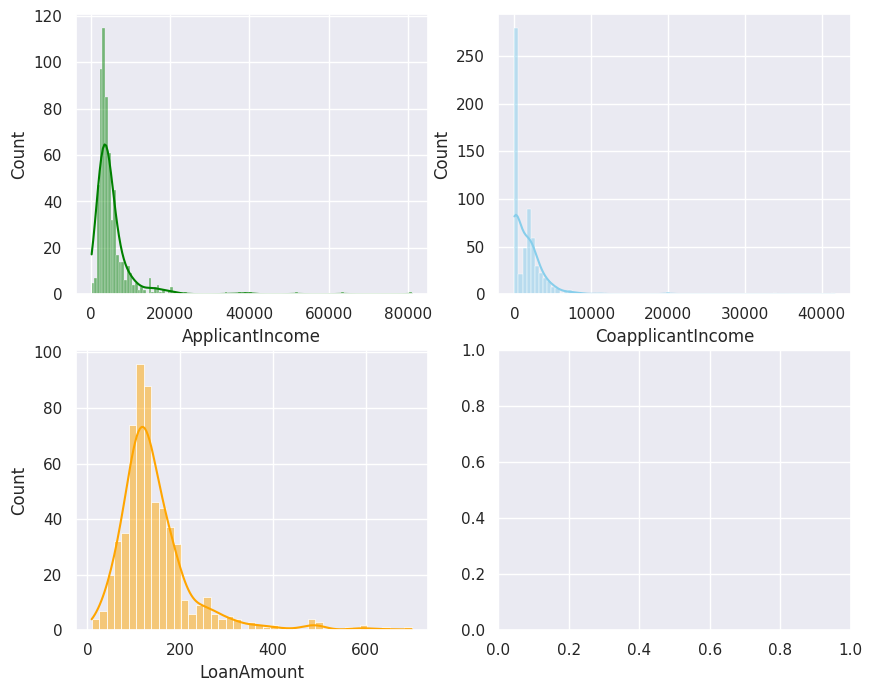

In [229]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(data=df, x="ApplicantIncome", kde=True, ax=axs[0, 0], color='green')
sns.histplot(data=df, x="CoapplicantIncome", kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=df, x="LoanAmount", kde=True, ax=axs[1, 0], color='orange')

In [230]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [231]:
for col in numerical_cols:
        df[col] = df[col].fillna(df[col].mean())

In [232]:
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [233]:
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.000000,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.000000,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.000000,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.000000,360.0,1.0,Urban,Y


In [234]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [235]:
for column in numerical_cols:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR  
    upper_bound = Q3 + 1.5 * IQR

    column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    # Print outliers for the current column
    if not column_outliers.empty:
        print(f"Outliers in {column}:")
        print(column_outliers)
        print()

Outliers in ApplicantIncome:
      Loan_ID  Gender  Married  Dependents  Education  Self_Employed  \
9    LP001020       1        1           1          0              0   
34   LP001100       1        0           3          0              0   
54   LP001186       0        1           1          0              1   
67   LP001233       1        1           1          0              0   
102  LP001350       1        1           0          0              0   
106  LP001369       1        1           2          0              0   
115  LP001401       1        1           1          0              0   
119  LP001422       0        0           0          0              0   
126  LP001448       1        1           3          0              0   
128  LP001451       1        1           1          0              1   
130  LP001469       1        0           0          0              1   
138  LP001492       1        0           0          0              0   
144  LP001508       1        1     

In [236]:
df.ApplicantIncome = np.log1p(df.ApplicantIncome)
df.CoapplicantIncome = np.log1p(df.CoapplicantIncome)
df.LoanAmount = np.log1p(df.LoanAmount)

<Axes: xlabel='LoanAmount', ylabel='Count'>

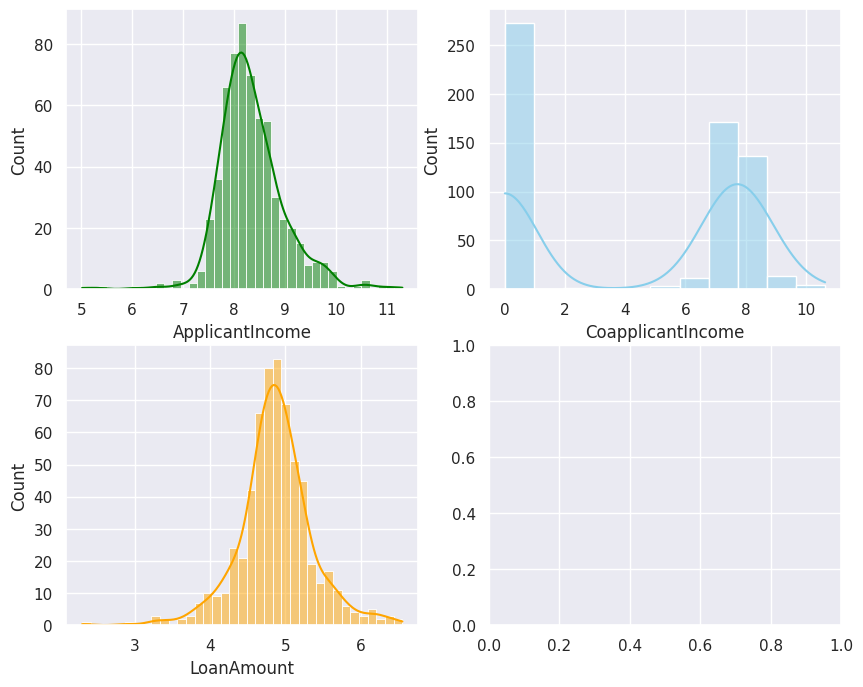

In [237]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(data=df, x="ApplicantIncome", kde=True, ax=axs[0, 0], color='green')
sns.histplot(data=df, x="CoapplicantIncome", kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=df, x="LoanAmount", kde=True, ax=axs[1, 0], color='orange')

In [238]:
df.Loan_Status.value_counts()

Loan_Status
1    422
0    192
Name: count, dtype: int64

In [239]:
df.drop('Loan_ID', axis=1, inplace=True)

## SMOTE

In [240]:
X = df.drop(["Loan_Status"], axis=1)
y = df["Loan_Status"]

In [241]:
from imblearn.over_sampling import SMOTE

X, y = SMOTE().fit_resample(X, y)

In [242]:
y.value_counts()

Loan_Status
1    422
0    422
Name: count, dtype: int64

In [243]:
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(X)

In [244]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [248]:
from sklearn.model_selection import cross_val_score

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}
cv = 5  # Number of folds in cross-validation

for name, model in models.items():
    # Perform cross-validation and compute mean accuracy
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    results[name] = scores.mean()

    print(f"{name} Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

print("\nModel Performance Summary (Mean CV Accuracy):")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")

Logistic Regression Cross-Validation Accuracy: 0.7467 ± 0.0342
Random Forest Cross-Validation Accuracy: 0.8119 ± 0.0327
SVM Cross-Validation Accuracy: 0.7496 ± 0.0236
KNN Cross-Validation Accuracy: 0.7363 ± 0.0418
Gradient Boosting Cross-Validation Accuracy: 0.7644 ± 0.0158

Model Performance Summary (Mean CV Accuracy):
Logistic Regression: 0.7467
Random Forest: 0.8119
SVM: 0.7496
KNN: 0.7363
Gradient Boosting: 0.7644


In [249]:
import optuna
# from sklearn.ensemble import RandomForestClassifier

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    # Create and evaluate model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')

    return cv_scores.mean()  # Maximize mean F1-score

# Run the optimization
study = optuna.create_study(direction="maximize")  # Maximize F1-score
study.optimize(objective, n_trials=50)  # Try 50 different sets of hyperparameters

# Best parameters
print("Best parameters:", study.best_params)


/home/nathalie/Desktop/projects/loan-prediction/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-03 21:29:45,308] A new study created in memory with name: no-name-97333da2-4931-4f43-9630-16d8abc521d1
[I 2025-03-03 21:29:47,042] Trial 0 finished with value: 0.7897040825039495 and parameters: {'n_estimators': 275, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7897040825039495.
[I 2025-03-03 21:29:47,627] Trial 1 finished with value: 0.7927947607664708 and parameters: {'n_estimators': 87, 'max_depth': 41, 'min_samples_split': 18, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.7927947607664708.
[I 2025-03-03 21:29:48,558] Trial 2 finished with value: 0.7953884735953701 and parameters: {'n_estimators': 143, 'max_depth': 49, 'min_samples

Best parameters: {'n_estimators': 219, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 1}


In [250]:
best_params = study.best_params
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=32, min_samples_split=5, n_estimators=219,
                       random_state=42)